In [1]:
#load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk,string,re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [2]:
import pymongo
import sys
import importlib

In [3]:
import dao.mongodb_dao
importlib.reload(dao.mongodb_dao)
from dao.mongodb_dao import MongoDbDao

In [4]:
import app_config

In [5]:
mongo_dao = MongoDbDao(app_config.db_conn_string)

In [6]:
df = mongo_dao.get_df_from_db(collection_name=app_config.collection_name, no_id=False)

In [7]:
df.head()

,_id,url,title,body,published,tag_text,month
0,5ee3a0276926072214243d92,https://www.bbc.com/news/world-middle-east-529...,Nabeel Rajab: Bahraini human rights activist f...,Bahrain has released a leading human rights ac...,9 June 2020,World,June
1,5ee3a0276926072214243d93,https://www.bbc.com/news/world-europe-52977739...,Spain ex-king Juan Carlos probed over Saudi ra...,Spain's Supreme Court has launched an investig...,9 June 2020,World,June
2,5ee3a0296926072214243d94,https://www.bbc.com/news/world-latin-america-5...,Discovering Colombia's rare flora and fauna,Colombia's tropical rainforests have been disa...,7 June 2020,World,June
3,5ee3a02a6926072214243d95,https://www.bbc.com/news/world-australia-52900...,Indigenous deaths in custody: Why Australians ...,Anger over the death of George Floyd has sprea...,5 June 2020,World,June
4,5ee3a02b6926072214243d96,https://www.bbc.com/news/world-latin-america-5...,Coronavirus: Hard-hit Brazil removes data amid...,Brazil has removed months of data on Covid-19 ...,7 June 2020,World,June


In [8]:
#check null values
df.isnull().sum()

_id          0
url          0
title        0
body         0
published    0
tag_text     0
month        0
dtype: int64

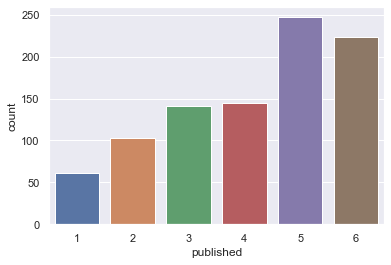

In [9]:
sns.countplot(df['published'].astype('datetime64').dt.month)

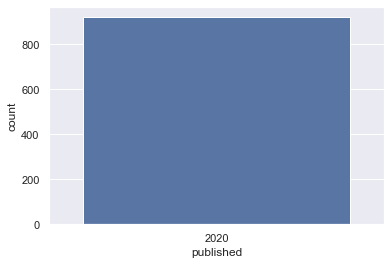

In [10]:
sns.countplot(df['published'].astype('datetime64').dt.year)

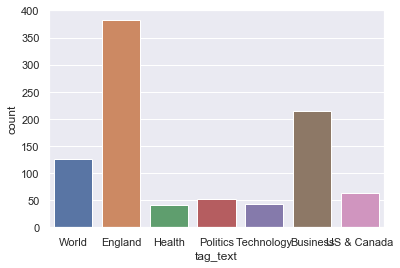

In [11]:
sns.countplot(df['tag_text'])

In [12]:
#append these three fields in one field
df['article']= df['title'].astype(str) +' '+df['body'].astype(str)
print('before preprocessing')
print(df['article'][0])

#tokenize articles to sentences
df['article']=df['article'].apply(lambda x: nltk.sent_tokenize(x))

#tokenize articles sentences to words
df['article']=df['article'].apply(lambda x: [nltk.word_tokenize(sent) for sent in x])

#lower case
df['article']=df['article'].apply(lambda x: [[wrd.lower() for wrd in sent] for sent in x])

#White spaces removal
df['article']=df['article'].apply(lambda x: [[wrd.strip() for wrd in sent if wrd != ' '] for sent in x])

#remove stop words 
stopwrds = set(stopwords.words('english'))
df['article']=df['article'].apply(lambda x: [[wrd for wrd in sent if not wrd in stopwrds] for sent in x])

#remove punctuation words
table = str.maketrans('', '', string.punctuation)
df['article']=df['article'].apply(lambda x: [[wrd.translate(table) for wrd in sent] for sent in x])

#remove not alphabetic characters
df['article']=df['article'].apply(lambda x: [[wrd for wrd in sent if wrd.isalpha()] for sent in x])

#lemmatizing article 
lemmatizer = WordNetLemmatizer()
df['article']=df['article'].apply(lambda x:[[lemmatizer.lemmatize(wrd.strip()) for wrd in sent ] for sent in x ])

#remove single characters
df['article']=df['article'].apply(lambda x: [[wrd for wrd in sent if len(wrd)>2] for sent in x])

#reformat article column to single text not nested lists
df['article']=df['article'].apply(lambda x:[' '.join(wrd) for wrd in x])
df['article']=df['article'].apply(lambda x:' '.join(x))

print('\n')
print('after preprocessing')
print(df['article'][0])

before preprocessing
Nabeel Rajab: Bahraini human rights activist freed from jail Bahrain has released a leading human rights activist who was sentenced to five years in jail for criticising the government on social media.Nabeel Rajab, 55, had been held since 2016 and convicted of offences including "spreading fake news".Rights groups condemned Rajab's treatment and a UN panel has called for his release.On Tuesday, Rajab's lawyer said his client would serve the remainder of his sentence in a non-custodial setting."Nabeel has been released and he is on his way home now," Mohammed Al-Jishi told the AFP news agency. "The court has finally agreed to grant [him] an alternative sentence."Bahrain introduced legislation in 2018 that allowed courts to convert jail terms into non-custodial sentences. Rajab is the first major opposition figure to be freed under this legislation, Reuters news agency reports.Rajab is the head of the Bahrain Center for Human Rights (BCHR) and played a leading role i

In [13]:
#TF IDF for article column
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_article=tfidf_vectorizer.fit_transform(df['article'])

In [14]:
#tf-idf output vectors
from sklearn.decomposition import PCA 
tfidf_pca = PCA(n_components = 2) 
tfidf_pca_comp = tfidf_pca.fit_transform(tfidf_article.toarray())

In [16]:
tfidf_pca_comp.shape

(920, 2)

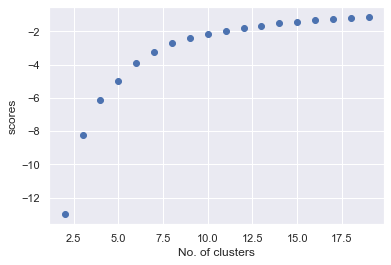

In [15]:
clusters=[]
kmeans_scores=[]
from sklearn.cluster import KMeans
K = range(2, 20)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(tfidf_pca_comp)
    kmeans_scores.append(k_means.score(tfidf_pca_comp))
    clusters.append(k)
plt.scatter(clusters,kmeans_scores)
plt.xlabel("No. of clusters")
plt.ylabel("scores")
plt.show()

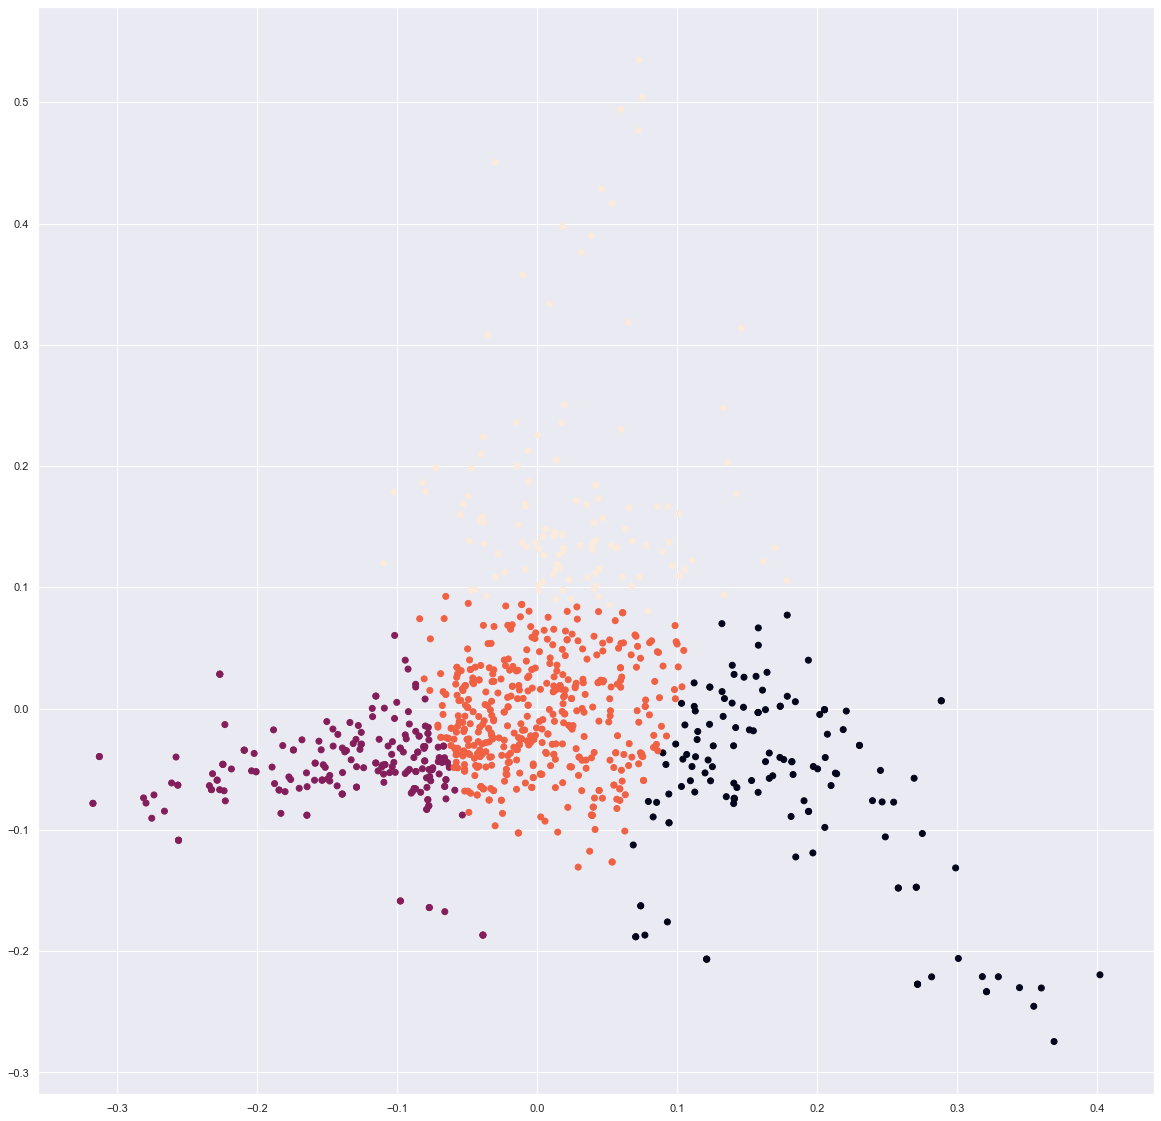

In [16]:
k_means = KMeans(n_clusters=4)
k_means.fit(tfidf_pca_comp)
pred=k_means.predict(tfidf_pca_comp)
plt.figure(figsize=(20,20))
plt.scatter(tfidf_pca_comp[:,0],tfidf_pca_comp[:,1],c=pred)
plt.show()

In [17]:
df['tfidf']=tfidf_article
df['tfidf_clusters']=pred
df.head()

,_id,url,title,body,published,tag_text,month,article,tfidf,tfidf_clusters
0,5ee3a0276926072214243d92,https://www.bbc.com/news/world-middle-east-529...,Nabeel Rajab: Bahraini human rights activist f...,Bahrain has released a leading human rights ac...,9 June 2020,World,June,nabeel rajab bahraini human right activist fre...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",2
1,5ee3a0276926072214243d93,https://www.bbc.com/news/world-europe-52977739...,Spain ex-king Juan Carlos probed over Saudi ra...,Spain's Supreme Court has launched an investig...,9 June 2020,World,June,spain exking juan carlos probed saudi rail dea...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",2
2,5ee3a0296926072214243d94,https://www.bbc.com/news/world-latin-america-5...,Discovering Colombia's rare flora and fauna,Colombia's tropical rainforests have been disa...,7 June 2020,World,June,discovering colombia rare flora fauna colombia...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",2
3,5ee3a02a6926072214243d95,https://www.bbc.com/news/world-australia-52900...,Indigenous deaths in custody: Why Australians ...,Anger over the death of George Floyd has sprea...,5 June 2020,World,June,indigenous death custody australian seizing pr...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",1
4,5ee3a02b6926072214243d96,https://www.bbc.com/news/world-latin-america-5...,Coronavirus: Hard-hit Brazil removes data amid...,Brazil has removed months of data on Covid-19 ...,7 June 2020,World,June,coronavirus hardhit brazil remove data amid ri...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",3


In [18]:
top_tf_df = pd.DataFrame(tfidf_article.todense()).groupby(df['tfidf_clusters']).mean()
top_tf_df

,0,1,2,3,4,5,6,7,8,9,...,25316,25317,25318,25319,25320,25321,25322,25323,25324,25325
tfidf_clusters,,,,,,,,,,,,,,,,,,,,,
0,0.000397,0.000000,0.000000,0.000359,0.000490,0.000000,0.00074,0.000872,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000425,0.000550,0.000000,0.00021,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000024,0.000284,0.000349,0.001187,0.000147,0.00000,0.000000,0.00026,0.000313,...,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101,0.000101
3,0.000000,0.000000,0.000000,0.000226,0.000264,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
for i,r in top_tf_df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([tfidf_vectorizer.get_feature_names()[t] for t in np.argsort(r)[-20:]]))


Cluster 0
world,year,customer,would,industry,travel,economic,coronavirus,firm,china,economy,airline,company,job,scheme,government,business,said,bank,loan

Cluster 1
bst,car,woman,people,charged,road,two,yorkshire,court,ghosn,black,death,fire,floyd,officer,protest,arrested,man,said,police

Cluster 2
trump,lockdown,minister,service,council,country,work,could,new,time,company,one,also,year,government,say,coronavirus,would,people,said

Cluster 3
week,country,resident,would,tested,say,government,number,case,death,staff,virus,health,people,patient,coronavirus,home,said,hospital,care


In [20]:
df['tfidf_clusters'].replace({0:"Business",1:"George Floyd",2:"Politics",3:"Coronavirus"},inplace=True)

In [21]:
df

,_id,url,title,body,published,tag_text,month,article,tfidf,tfidf_clusters
0,5ee3a0276926072214243d92,https://www.bbc.com/news/world-middle-east-529...,Nabeel Rajab: Bahraini human rights activist f...,Bahrain has released a leading human rights ac...,9 June 2020,World,June,nabeel rajab bahraini human right activist fre...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics
1,5ee3a0276926072214243d93,https://www.bbc.com/news/world-europe-52977739...,Spain ex-king Juan Carlos probed over Saudi ra...,Spain's Supreme Court has launched an investig...,9 June 2020,World,June,spain exking juan carlos probed saudi rail dea...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics
2,5ee3a0296926072214243d94,https://www.bbc.com/news/world-latin-america-5...,Discovering Colombia's rare flora and fauna,Colombia's tropical rainforests have been disa...,7 June 2020,World,June,discovering colombia rare flora fauna colombia...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics
3,5ee3a02a6926072214243d95,https://www.bbc.com/news/world-australia-52900...,Indigenous deaths in custody: Why Australians ...,Anger over the death of George Floyd has sprea...,5 June 2020,World,June,indigenous death custody australian seizing pr...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",George Floyd
4,5ee3a02b6926072214243d96,https://www.bbc.com/news/world-latin-america-5...,Coronavirus: Hard-hit Brazil removes data amid...,Brazil has removed months of data on Covid-19 ...,7 June 2020,World,June,coronavirus hardhit brazil remove data amid ri...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Coronavirus
...,...,...,...,...,...,...,...,...,...,...
915,5ee3ae6f6926072214244125,https://www.bbc.com/news/world-africa-51063149,Trump says he deserves Nobel Peace Prize not A...,US President Donald Trump seems to think that ...,10 January 2020,World,January,trump say deserves nobel peace prize abiy ahme...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics
916,5ee3b0076926072214244126,https://www.bbc.com/news/world-us-canada-51345...,Congresswoman Rashida Tlaib regrets booing Hil...,Congresswoman Rashida Tlaib says she regrets b...,2 February 2020,US & Canada,February,congresswoman rashida tlaib regret booing hill...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics
917,5ee3b0076926072214244127,https://www.bbc.com/news/world-us-canada-52224...,Linda Tripp: Woman who revealed Clinton-Lewins...,An American civil servant whose disclosure of ...,8 April 2020,US & Canada,April,linda tripp woman revealed clintonlewinsky sca...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",George Floyd
918,5ee3b0086926072214244128,https://www.bbc.com/news/world-us-canada-51769...,Bill Clinton claims Monica Lewinsky affair was...,Former President Bill Clinton says his affair ...,6 March 2020,US & Canada,March,bill clinton claim monica lewinsky affair help...,"(0, 24370)\t0.0350476956779859\n (0, 13306)...",Politics


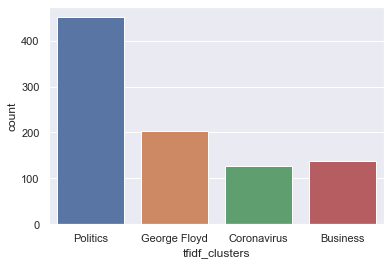

In [22]:
sns.countplot(df['tfidf_clusters'])

In [23]:
df.to_csv("articles_clustered.csv")